In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
print(sys.executable)

/usr/bin/python3


In [2]:
# No beam effects and crossing angle hepmc file: 
# Taken from https://dtn01.sdcc.bnl.gov:9000/minio/eictest/ATHENA/WG/BeamEffects/
no_effects_source = "/home/romanov/eic/data/test_headon_25mRad_18x275.hepmc"

# Full pythia8 with beam effects file: 
# Taken from https://dtn01.sdcc.bnl.gov:9000/minio/eictest/ATHENA/EVGEN/DIS/NC/18x275/minQ2=10/
full_py8_source = "/home/romanov/eic/data/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.hepmc"
executable = "/home/romanov/eic/afterburner/cpp/cmake-build-debug/abconvert/abconv"
process_limit = 20000

# We compare setups here: 
# 1. No beam effects, No afterburner
# 2. No beam effects + afterburner
# 3. Full beam effects (No afterburner obviously)

# Each setup will produce hepmc and .root file + command to run converter/afterburner

# 1. No effects, No afterburner
no_effects_out = "no_effects"
no_effects_root = no_effects_out + ".hist.root"
no_effects_cmd = f"{executable} {no_effects_source} -i hepmc2 --ab-off --limit={process_limit} -o {no_effects_out}"

# 2. No beam effects run through afterburner
afterburner_out = "afterburner"
afterburner_root = afterburner_out + ".hist.root"
afterburner_cmd = f"{executable} {no_effects_source} -i hepmc2 --limit={process_limit} -o {afterburner_out}"

# 3. Full beam effects (No afterburner obviously)
full_py8_out = "full_eff"
full_py8_root = full_py8_out + ".hist.root"
full_py8_cmd = f"{executable} {full_py8_source}  -i hepmc2 --ab-off --limit={process_limit} -o {full_py8_out}"


The next one will trigger simulations for 1. no effects 

In [3]:
print("\n\n", no_effects_cmd)
!{no_effects_cmd}
print("\n\n", afterburner_cmd)
!{afterburner_cmd}
print("\n\n", full_py8_cmd)
!{full_py8_cmd}



 /home/romanov/eic/afterburner/cpp/cmake-build-debug/abconvert/abconv /home/romanov/eic/data/test_headon_25mRad_18x275.hepmc -i hepmc2 --ab-off --limit=20000 -o no_effects
Afterburner is DISABLED
Initial beam particles (before afterburner):
   pdg: 2212   p: 0.0, 0.0, 275.0   e:275.0
   pdg: 11   p: 0.0, -0.0, -18.0   e:18.0
   crossing angle: 0 [mrad]
Events parsed: 1000
Events parsed: 2000
Events parsed: 3000
Events parsed: 4000
Events parsed: 5000
Events parsed: 10000
Events parsed: 15000
Events parsed: 20000
Event limit reached:-> Events processed: 20000 >= Events_limit: 20000


 /home/romanov/eic/afterburner/cpp/cmake-build-debug/abconvert/abconv /home/romanov/eic/data/test_headon_25mRad_18x275.hepmc -i hepmc2 --limit=20000 -o afterburner
Afterburner is ENABLED
AFTERBURNER CONFIGURATION
Vertex distribution width  x: 0.00671564, y: 0.000601655, z: 3.16228, t: 0.105482
Vertex distribution function: Gauss
Beam direction: A  theta-phi = 0.025, 0
Beam direction: B  theta-phi = 3.1415

In [4]:
#!ls -latrh
# !rm *.root *.hepmc

In [5]:
no_effects_file = uproot.open(no_effects_root)
no_effects_file.keys()
afterburner_file = uproot.open(afterburner_root)
full_py8_file = uproot.open(full_py8_root)

files = [no_effects_file, afterburner_file, full_py8_file]
file_titles = ["Nominal (no effects)", "Afterburner", "Pythia8 with beam effects"]

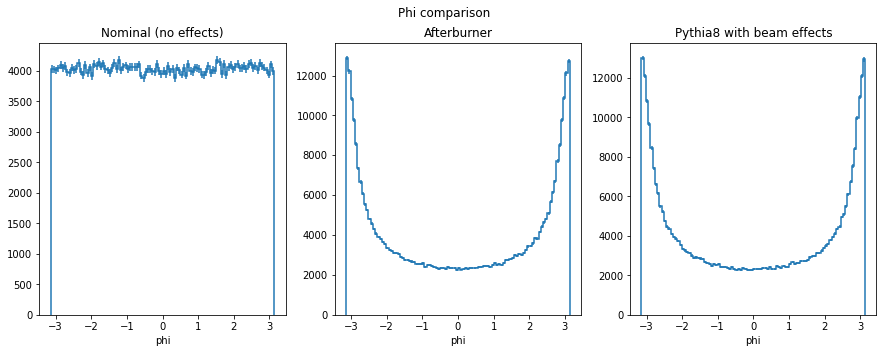

In [6]:
def compare_1d(histo_name, title, x_label, y_label, figsize=(15, 5)):

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title)
    
    for i, ax in enumerate(axes):
        ax.set_title(file_titles[i])
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        files[i][histo_name].to_hist().plot(ax=ax)
    

compare_1d("partPhi", "Phi comparison", "phi", "")

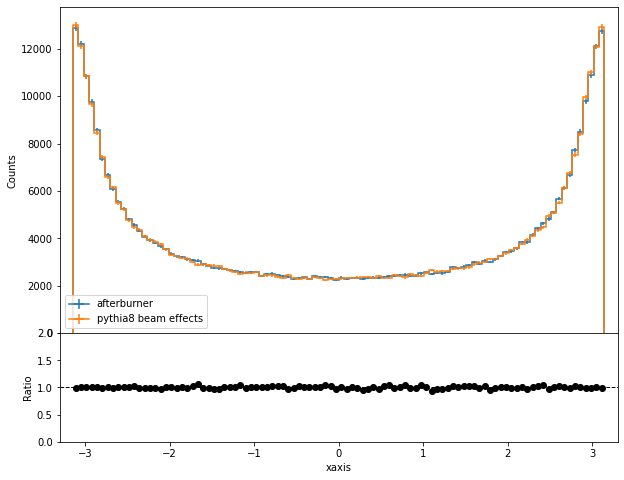

In [7]:
fig = plt.figure(figsize=(10, 8))

ab_phi_hist = afterburner_file['partPhi'].to_hist()
py8_phi_hist = full_py8_file['partPhi'].to_hist()

# Comparison plot
top_art, bottom_art = ab_phi_hist.plot_ratio(
    py8_phi_hist,
    rp_num_label="afterburner",
    rp_denom_label="pythia8 beam effects")

bottom_art.line.axes.set_ylim(0, 2)
bottom_art.line.axes.set_xlim(-3.3, 3.3)
fig.savefig('pics/phi_comparison.png', dpi=224)

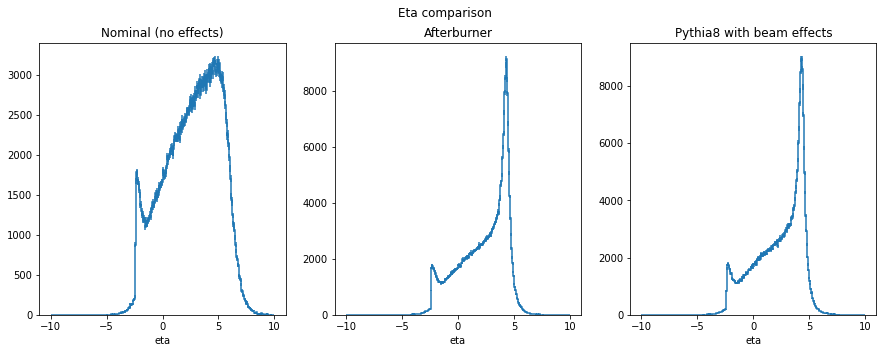

In [8]:
compare_1d('partEta', 'Eta comparison', 'eta', '')

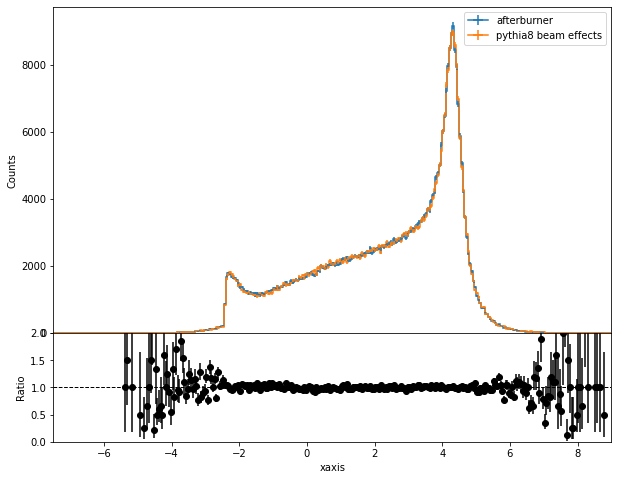

In [9]:
fig = plt.figure(figsize=(10, 8))

ab_eta_hist = afterburner_file['partEta'].to_hist()
py8_eta_hist = full_py8_file['partEta'].to_hist()

# Comparison plot
top_art, bottom_art = ab_eta_hist.plot_ratio(
    py8_eta_hist,
    rp_num_label="afterburner",
    rp_denom_label="pythia8 beam effects")

bottom_art.line.axes.set_ylim(0, 2)
bottom_art.line.axes.set_xlim(-7.5, 9)
fig.savefig('pics/eta_comparison.png', dpi=224)

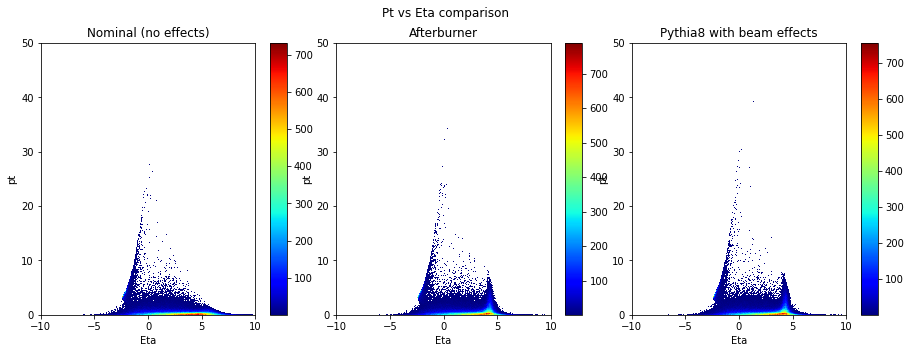

In [10]:
my_cmap = mpl.cm.get_cmap("jet").copy()
my_cmap.set_under('w',1)

def compare_2d_plots(histo_name, title, x_label, y_label, figsize=(15, 5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(title)
    
    ax1.set_title("Nominal (no effects)")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    no_effects_file[histo_name].to_hist().plot(ax=ax1, vmin=1, cmap=my_cmap)

    ax2.set_title("Afterburner")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    afterburner_file[histo_name].to_hist().plot(ax=ax2, vmin=1, cmap=my_cmap)

    ax3.set_title("Pythia8 with beam effects")
    ax3.set_xlabel(x_label)
    ax3.set_ylabel(y_label)
    full_py8_file[histo_name].to_hist().plot(ax=ax3, vmin=1, cmap=my_cmap)
    file_name = ('pics/'+title+'.png').replace(' ', '_').lower()
    fig.savefig(file_name, dpi=224)


compare_2d_plots('partPtVsEta', 'Pt vs Eta comparison', 'Eta', 'pt[GeV]')

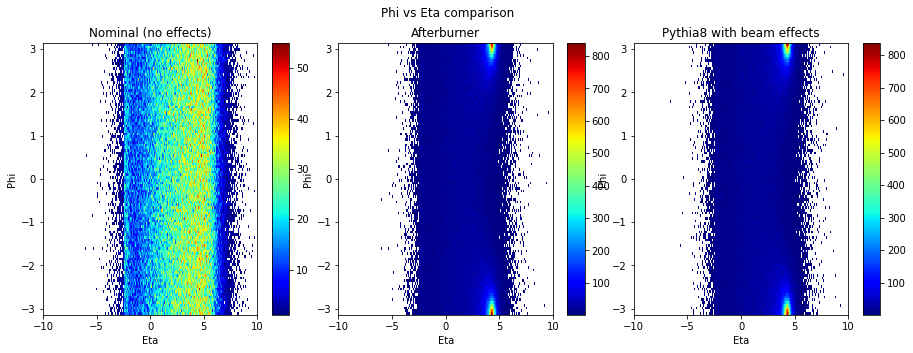

In [11]:
compare_2d_plots('partPhiVsEta', 'Phi vs Eta comparison', 'Eta', 'Phi')